
# Investigation of ODI Cricket Data Through Machine Learning

With the 2019 ICC Cricket World Cup now in full swing, I wanted to dig a little deeper into the statistics behind this weird and wonderful game.

There is a vast amount of data collected within cricket. Every ball bowled represents a potentially interesting data point (runs scored, wickets taken), and each has the potential to follow patterns. This project will attempt to identify these patterns through various machine learning techniques, and see what it really takes to win a cricket match.

In the One Day Internation (ODI) format, the team batting first will have 50 overs (6 balls in an over) to amas as higher score as possible whilst the other team attempt to take wickets and limit their score. The second team will then have 50 overs to try and chase down that score. Either team can lose a maximum of 10 wickets within the 50 over innings.

## Data



The dataset we are focussing on is available to download from [this](https://www.kaggle.com/venky73/icc-cricket-world-cup-2019-analysis) Kaggle kernel. The data has been scraped from [https://www.espncricinfo.com/](https://www.espncricinfo.com/) and split into 6 dataframes contained within .csv files. File overview:
1. **ODI_Match_Results.csv** - Contains data regarding the teams involved, who won the toss and whether they chose to bat first or second, what the outcome of the match was, where and when it was played.
1. **ODI_Match_Totals.csv** - Contains data regarding the scores achieved by each team, winning margin, match result, and some data regarding the teams involved, when and where the match played is repeated here.
1. **WC_players.csv** - Contains player information.
1. **Ground_Averages.csv** - Contains aggregated data from various cricket grounds around the world.
1. **Bowler_data.csv** - Contains bowling figures such as balls bowled, wickets taken and bowling economoy.
1. **Batsman_Data.csv** - Contains batting data such as balls faced, runs scored, strike rate, number of boundaries scored.

Initial analysis will focus on the first two dataframes to build up an insight on the following questions:
1. Which team has the highest win percentage?
1. Which teams are most successful in England?
1. Given that a team wins the toss, what is the probability that they win the game?
1. What team is most successful if a toss is won, and which is most successful if a toss is lost?
1. What is the most common choice for each of the English grounds?
1. What is the probability that a team wins their next game, given that the result of their previous game?

Linear Regression models:
* Win predictor
    * Using game stats
    * Using batsmen/ bowler stats
    * Using all stats
    * Using WC matches as a test set.
* Score predictor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

df_match = pd.read_csv('../Data/raw/ODI_Match_Results.csv')
df_totals = pd.read_csv('../Data/raw/ODI_Match_Totals.csv')
df_players = pd.read_csv('../Data/raw/WC_players.csv')
df_ground = pd.read_csv('../Data/raw/Ground_Averages.csv')
df_bowl = pd.read_csv('../Data/raw/Bowler_data.csv')
df_bat = pd.read_csv('../Data/raw/Batsman_Data.csv')

## Assess Data Cleanliness & Tidiness
***
In this section we will assess and document the cleanliness and tidiness of each dataframe, starting with the two key dataframes of interest for match win prediction: `df_match` and `df_totals`.

In [2]:
df_match.shape, df_totals.shape

((1322, 12), (1296, 13))

The dataframes are not equal in size along the zero axis. df_totals potentially missing some data.

In [3]:
df_match

,Unnamed: 0,Result,Margin,BR,Toss,Bat,Opposition,Ground,Start Date,Match_ID,Country,Country_ID
0,418,won,85 runs,NaN,lost,1st,v India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan,7
1,692,lost,85 runs,NaN,won,2nd,v Pakistan,Kolkata,3 Jan 2013,ODI # 3315,India,6
2,419,lost,10 runs,NaN,lost,2nd,v India,Delhi,6 Jan 2013,ODI # 3316,Pakistan,7
3,693,won,10 runs,NaN,won,1st,v Pakistan,Delhi,6 Jan 2013,ODI # 3316,India,6
4,121,lost,107 runs,NaN,lost,2nd,v Australia,Melbourne,11 Jan 2013,ODI # 3317,SriLanka,8
5,1096,won,107 runs,NaN,won,1st,v Sri Lanka,Melbourne,11 Jan 2013,ODI # 3317,Australia,2
6,694,lost,9 runs,NaN,lost,2nd,v England,Rajkot,11 Jan 2013,ODI # 3318,India,6
7,852,won,9 runs,NaN,won,1st,v India,Rajkot,11 Jan 2013,ODI # 3318,England,1
8,122,won,8 wickets,59.0,won,2nd,v Australia,Adelaide,13 Jan 2013,ODI # 3319,SriLanka,8
9,1097,lost,8 wickets,59.0,lost,1st,v Sri Lanka,Adelaide,13 Jan 2013,ODI # 3319,Australia,2


In [4]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 12 columns):
Unnamed: 0    1322 non-null int64
Result        1322 non-null object
Margin        1322 non-null object
BR            606 non-null float64
Toss          1322 non-null object
Bat           1322 non-null object
Opposition    1322 non-null object
Ground        1322 non-null object
Start Date    1322 non-null object
Match_ID      1322 non-null object
Country       1322 non-null object
Country_ID    1322 non-null int64
dtypes: float64(1), int64(2), object(9)
memory usage: 124.0+ KB


In [5]:
df_match.Match_ID.value_counts()

ODI # 3728    2
ODI # 3388    2
ODI # 3427    2
ODI # 3724    2
ODI # 3446    2
ODI # 3973    2
ODI # 3943    2
ODI # 3911    2
ODI # 4137    2
ODI # 3871    2
ODI # 4029    2
ODI # 3416    2
ODI # 3376    2
ODI # 3630    2
ODI # 3918    2
ODI # 3726    2
ODI # 3737    2
ODI # 4038    2
ODI # 3861    2
ODI # 3976    2
ODI # 3549    2
ODI # 3982    2
ODI # 3922    2
ODI # 4027    2
ODI # 4043    2
ODI # 3795    2
ODI # 3880    2
ODI # 3739    2
ODI # 3970    2
ODI # 3789    2
             ..
ODI # 3503    1
ODI # 4037    1
ODI # 3504    1
ODI # 4003    1
ODI # 3686    1
ODI # 4002    1
ODI # 3767    1
ODI # 3762    1
ODI # 3612    1
ODI # 3761    1
ODI # 3553    1
ODI # 3408    1
ODI # 4101    1
ODI # 3621    1
ODI # 3697    1
ODI # 3665    1
ODI # 4004    1
ODI # 3505    1
ODI # 3703    1
ODI # 3576    1
ODI # 3904    1
ODI # 3518    1
ODI # 4006    1
ODI # 4049    1
ODI # 3507    1
ODI # 3746    1
ODI # 4057    1
ODI # 4061    1
ODI # 3359    1
ODI # 3962    1
Name: Match_ID, Length: 

In [6]:
df_match.shape[0] - df_match.Match_ID.duplicated(keep=False).sum(), df_match.Match_ID.duplicated().sum()

(196, 563)

In [7]:
df_match.Result.value_counts()

won     663
lost    562
n/r      54
aban     22
tied     14
canc      4
-         3
Name: Result, dtype: int64

Unnamed: 0      0
Result          3
Margin         97
BR            716
Toss           26
Bat            30
Opposition      0
Ground          0
Start Date      0
Match_ID        0
Country         0
Country_ID      0
dtype: int64


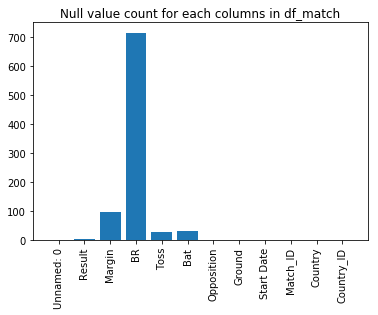

In [8]:
nulls = (df_match == "-").sum() + (df_match.isnull().sum())
print(nulls)

plt.bar(x=nulls.index, height=nulls.values)
plt.xticks(rotation=90);
plt.title("Null value count for each columns in df_match");

### `df_match` cleanliness
- Column names include capital letters and whitsepace characters.
- `Unnamed: 0` appears to be an old index which is no longer useful.
- `BR` non-descriptive name for "Balls Remaining"
- `BR` has 606 null value entries
- "-" is used in place of NaN in `Margin`, `Toss`, `Bat` and `Result` columns
- `Start Date` not in datetime format.
- `Result`, `Toss`, `Bat` columns should be categorical type instead of object.
- `Match_ID` has common prefix "ODI #".
- some `Match_ID` values have suffix "a".
- `Margin` has "runs" and "wickets" suffixes to describe the winning method. Need to separate these to convert to integer.
- `Opposition` column has common prefix "v _Country_"
- `Result` has multiple entries likely to mean match abandoned. \['n/r', 'aban', 'canc'\].
- 563 matches are represented by 2 rows of data, 196 matches are represented by a single row of data. Most data can be inferred from the single row but some might be missing.

## Assess Data Cleanliness & Tidiness

Now that we have cleaned df_match and exported as a clean.csv file we'll assess the cleanliness of the df_totals and implement the cleaning scripts used previously.

In [9]:
df_totals

,Unnamed: 0,Score,Overs,RPO,Target,Inns,Result,Opposition,Ground,Start Date,Match_ID,Country,Country_ID
0,412,250,48.3,5.15,NaN,1,won,v India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan,7
1,680,165,48.0,3.43,251.0,2,lost,v Pakistan,Kolkata,3 Jan 2013,ODI # 3315,India,6
2,413,157,48.5,3.21,168.0,2,lost,v India,Delhi,6 Jan 2013,ODI # 3316,Pakistan,7
3,681,167,43.4,3.82,NaN,1,won,v Pakistan,Delhi,6 Jan 2013,ODI # 3316,India,6
4,117,198,40.0,4.95,306.0,2,lost,v Australia,Melbourne,11 Jan 2013,ODI # 3317,SriLanka,8
5,1076,305/5,50.0,6.10,NaN,1,won,v Sri Lanka,Melbourne,11 Jan 2013,ODI # 3317,Australia,2
6,682,316/9,50.0,6.32,326.0,2,lost,v England,Rajkot,11 Jan 2013,ODI # 3318,India,6
7,836,325/4,50.0,6.50,NaN,1,won,v India,Rajkot,11 Jan 2013,ODI # 3318,England,1
8,118,172/2,40.1,4.28,171.0,2,won,v Australia,Adelaide,13 Jan 2013,ODI # 3319,SriLanka,8
9,1077,170,46.5,3.62,NaN,1,lost,v Sri Lanka,Adelaide,13 Jan 2013,ODI # 3319,Australia,2


In [10]:
df_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 13 columns):
Unnamed: 0    1296 non-null int64
Score         1296 non-null object
Overs         1296 non-null float64
RPO           1296 non-null object
Target        620 non-null float64
Inns          1296 non-null int64
Result        1296 non-null object
Opposition    1296 non-null object
Ground        1296 non-null object
Start Date    1296 non-null object
Match_ID      1296 non-null object
Country       1296 non-null object
Country_ID    1296 non-null int64
dtypes: float64(2), int64(3), object(8)
memory usage: 131.7+ KB


In [11]:
df_totals.Inns.value_counts()

1    656
2    620
0     20
Name: Inns, dtype: int64

In [12]:
df_totals.Match_ID.duplicated().sum(), df_totals.shape[0] - df_totals.Match_ID.duplicated(keep=False).sum()

(554, 188)

Unnamed: 0      0
Score           0
Overs           0
RPO            20
Target        676
Inns            0
Result          3
Opposition      0
Ground          0
Start Date      0
Match_ID        0
Country         0
Country_ID      0
dtype: int64


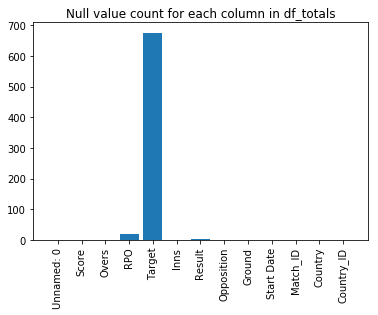

In [13]:
nulls = (df_totals == "-").sum() + df_totals.isnull().sum()
print(nulls)
plt.bar(x=nulls.index, height=nulls.values);
plt.xticks(rotation=90);
plt.title("Null value count for each column in df_totals");

### `df_totals` Cleanliness
- Column names include capital letters and whitsepace characters.
- `Unnamed: 0` appears to be an old index which is no longer useful.
- `Score` is type object because it is sometimes given in the format "###/#" where the number after "/" is the amount of wickets lost. 
- `Result` and `RPO` have "-" in place of NaN values
- `Target` has 676 NaN values because the team batting first does not have a target score.
- `Inns` is a non-descriptive term for "innings batted".
- `Inns` has some zero values associated with abandoned matches
- `RPO` is type object, should by type float.
- `Start Date` not in datetime format.
- `Result`, `Inns` columns should be categorical type.
- `Match_ID` has common prefix "ODI #".
- 554 matches are represented by 2 rows of data, and 188 matches are represented by a single row of data. Most data can be inferred from the single row but some might be missing.
***
### Tidiness
- Columns duplicated between `df_match` and `df_totals`: `Start Date`, `Ground`, `Match_ID`, `Country`, `Country_ID`, `Opposition`, `Result`.
- Some data across both tables can be inferred from other columns and therefore are not independant variables. Related columns: `Score`, `Overs`, `RPO`, `BR`, `Target`, `Margin`
- Data can be restructured into 2 tables with only the `Match_ID` column common between them. 
***
### Next Steps
 - Restructure data so that we have 2 new DataFrames.
 - `df_match_clean` will have the following columns


- RPO is a non-descriptive heading for "Runs Per Over", I will change this to run_rate
- Inns is a non-descriptive name for the innings in which a team has batted. There are some 0 values which are potential null values. For now we'll leave as they are and compare with the bat_1st column in ODI_match_clean.
- Some columns headings have white spaces.
- Target has a lot of null values. All other columns have no null values.
- Score and RPO columns are `object` type which we will convert to float.
- Score is sometimes given in the form "120/8", meaning 8 wickets were taken. We'll separate this out to have score and wickets columns in numerical type.
- 554 matches are represented by 2 rows of data, and 188 matches are represented by a single row of data. It would be tidier if we represented each game in a single row of data.
- Start date is not in datetime format
- Match_ID has a standard format starting with 'ODI #', we can remove this prefix.
- Opposition country in format "v Country", we can remove the "v " prefix
- Unnamed:\_0 likely was an index value and can be dropped.
- RPO and Result columns have 20 and 3 "-" values in the dataset which we will replace with NaN.

## Assessment Summary
***
### `df_match` cleanliness
- Column names include capital letters and whitsepace characters.
- `Unnamed: 0` appears to be an old index which is no longer useful.
- `BR` non-descriptive name for "Balls Remaining"
- `BR` has 606 null value entries.
- "-" is used in place of NaN in `Margin`, `Toss`, `Bat` and `Result` columns
- `Start Date` not in datetime format.
- `Result`, `Toss`, `Bat` columns should be categorical type instead of object.
- `Match_ID` has common prefix "ODI #".
- some `Match_ID` values have suffix "a".
- `Margin` has "runs" and "wickets" suffixes to describe the winning method. Need to separate these to convert to integer.
- `Opposition` column has common prefix "v _Country_"
- `Result` has multiple entries likely to mean match abandoned. \['n/r', 'aban', 'canc'\].
- 563 matches are represented by 2 rows of data, 196 matches are represented by a single row of data. Most data can be inferred from the single row but some might be missing.

`BR` has a large amount of NaN values, but this missing data can be calculated from `df_totals['Overs']` column.
*** 
### `df_totals` Cleanliness
- Column names include capital letters and whitsepace characters.
- `Unnamed: 0` appears to be an old index which is no longer useful.
- `Score` is type object because it is sometimes given in the format "###/#" where the number after "/" is the amount of wickets lost. 
- `Result` and `RPO` have "-" in place of NaN values
- `Target` has 676 NaN values because the team batting first does not have a target score.
- `Inns` is a non-descriptive term for "innings batted".
- `Inns` has some zero values associated with abandoned matches
- `RPO` is type object, should by type float.
- `Start Date` not in datetime format.
- `Result`, `Inns` columns should be categorical type.
- `Match_ID` has common prefix "ODI #".
- 554 matches are represented by 2 rows of data, and 188 matches are represented by a single row of data. Most data can be inferred from the single row but some might be missing.
***
### Tidiness
- Columns duplicated between `df_match` and `df_totals`: `Start Date`, `Ground`, `Match_ID`, `Country`, `Country_ID`, `Opposition`, `Result`.
- Some data across both tables can be inferred from other columns and therefore are not independant variables. Related columns: `Score`, `Overs`, `RPO`, `BR`, `Target`, `Margin`
- Data can be restructured into 2 tables with only the `Match_ID` column common between them. 
***
### Next Steps
 1. Restructure data so that we have 2 new DataFrames; `df_match_clean`, `df_totals_clean`.
     - `df_match_clean`:
         - columns: `match_id`, `start_date`, `team1`, `team2`, `ground`, `result`
         - Each match represented by a single row
         - `result` column will contain the winning team for all completed games that were not tied.
     - `df_totals_clean`:
         - columns: `match_id`, `team`, `opposition`, `toss`, `innings`, `score`, `overs`, `rpo`, `result`, `win_margin`, `win_method`
         - Each match will be represented by two rows of data, one for each team.
         - `result` column will contain "win, lose, draw, n/r" categorical data.
         <br>
         <br>
 2. Implement and test cleaning code on the `df_match_clean` and `df_totals_clean` to address cleanliness issues.
     



## Cleaning & Testing: `df_match`
***
In this section we will implement and test code to address all of the isssues in the assessment sumary above.  Firstly, we will make copies of `df_match` and `df_totals` to maintain the integrity of the data.

In [14]:
df_match_clean = df_match.copy()

### Assessment
 - Column names include capital letters and whitsepace characters.
 - `Opposition` column has common prefix "v _Country_"
 - Restructure data so that we have 2 new DataFrames; `df_match_clean`, `df_scores_clean`.
 - `df_match_clean`:
     - columns: `match_id`, `start_date`, `team1`, `team2`, `ground`, `result`
     - Each match represented by a single row
     - `result` column will contain the winning team for all completed games that were not tied.
*** ***
### Define
 - Make all column names lower case with whitsepace characters replace with "_".
 - Update `result` column to contain the winning team name using `np.where()`
     - It will be more efficient remove the "v _Country_" prefix from the `opposition` column before this step. We'll do this with string slicing.
 - Drop rows with duplicated match id's.
 - Drop columns: `unnamed:_0`, `margin`,`br`, `toss`, `bat`, `country_id` using `pd.drop()`
 - Rename `country` and `oppostion` to `team1` and `team2`.
 - Reorder columns: `match_id`, `start_date`, `team1`, `team2`, `ground`, `result`
 

In [15]:
def renameCols(df):
    '''
    Rename all column headers lower case with whitespace removed.
    '''
    df.rename(lambda c: c.lower().replace(' ', '_'), axis=1, inplace=True)
    
renameCols(df_match_clean)
df_match_clean.head(1)

,unnamed:_0,result,margin,br,toss,bat,opposition,ground,start_date,match_id,country,country_id
0,418,won,85 runs,NaN,lost,1st,v India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan,7


### Assessment
 - `Opposition` column has common prefix "v _Country_"
*** ***
### Define
 - It will be more efficient remove the "v _Country_" prefix from the `opposition` column before this step. We'll do this with string slicing.
***
### Code

In [16]:
df_match_clean['opposition'] = df_match_clean['opposition'].str[2:]
df_match_clean.opposition.value_counts()

Sri Lanka       146
India           145
England         139
Australia       129
New Zealand     126
South Africa    122
Pakistan        118
West Indies     103
Zimbabwe         99
Bangladesh       76
Ireland          56
Afghanistan      22
Scotland         22
U.A.E.           11
Hong Kong         4
Kenya             2
P.N.G.            1
Netherlands       1
Name: opposition, dtype: int64

### Assessment
 - `df_match_clean`:
     - columns: `match_id`, `start_date`, `team1`, `team2`, `ground`, `result`
     - Each match represented by a single row
     - `result` column will contain the winning team for all completed games that were not tied.
*** ***
### Define
 - Update `result` column to contain the winning team name using `np.where()`
 - Drop rows with duplicated match id's.
 - Drop columns: `unnamed:_0`, `margin`,`br`, `toss`, `bat`, `country_id` using `pd.drop()`
 - Rename `country` and `oppostion` to `team1` and `team2`.
 - Reorder columns: `match_id`, `start_date`, `team1`, `team2`, `ground`, `result`
 

In [17]:
df_match_clean['result'] = np.where(df_match_clean.result == "won", df_match_clean.country,
                                   np.where(df_match_clean.result == "lost", df_match_clean.opposition, df_match_clean.result))
df_match_clean.result.value_counts()

India           183
England         154
Australia       141
Pakistan        104
SouthAfrica      82
Bangladesh       77
Newzealad        73
South Africa     69
New Zealand      68
SriLanka         63
n/r              54
Sri Lanka        54
Afghanistan      53
WestIndies       39
West Indies      26
aban             22
Zimbabwe         21
tied             14
Ireland          11
canc              4
-                 3
Scotland          3
U.A.E.            3
Hong Kong         1
Name: result, dtype: int64

In [18]:
def renameCols2(df, old_name_list, new_name_list):
    '''
    Rename columns in old_name_list with names in new_name_list.
    Pre-condition: len(old_name_list) == len(new_name_list)
    '''
    for i in range(len(old_name_list)):
        df.rename(columns={old_name_list[i]:new_name_list[i]}, inplace=True)
        
old_names = ['country', 'opposition']
new_names = ['team1', 'team2']
        
renameCols2(df_match_clean, old_names, new_names)

df_match_clean.head(1)

,unnamed:_0,result,margin,br,toss,bat,team2,ground,start_date,match_id,team1,country_id
0,418,Pakistan,85 runs,NaN,lost,1st,India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan,7


In [19]:
drop_cols = ['unnamed:_0', 'margin','br', 'toss', 'bat', 'country_id']
df_match_clean.drop(drop_cols, axis=1, inplace=True)
df_match_clean.head(1)

,result,team2,ground,start_date,match_id,team1
0,Pakistan,India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan


In [20]:
# Test for known duplicates of match_id
assert not df_match_clean.match_id.duplicated().any()

AssertionError: 

In [21]:
drop_index = df_match_clean[df_match_clean.match_id.duplicated()].index
df_match_clean.drop(drop_index, axis=0, inplace=True)

In [22]:
# Test that all duplicates of match_id are dropped
assert not df_match_clean.match_id.duplicated().any()

In [23]:
ordered_cols = ['match_id', 'start_date', 'team1', 'team2', 'ground', 'result']
df_match_clean = df_match_clean[ordered_cols]
df_match_clean.head()

,match_id,start_date,team1,team2,ground,result
0,ODI # 3315,3 Jan 2013,Pakistan,India,Kolkata,Pakistan
2,ODI # 3316,6 Jan 2013,Pakistan,India,Delhi,India
4,ODI # 3317,11 Jan 2013,SriLanka,Australia,Melbourne,Australia
6,ODI # 3318,11 Jan 2013,India,England,Rajkot,England
8,ODI # 3319,13 Jan 2013,SriLanka,Australia,Adelaide,SriLanka


### Assessment
- `Match_ID` has common prefix "ODI #".
- some `Match_ID` values have suffix "a".
***
### Define
- Extract digits from the string using `.str.extract(regex)`.
***
### Code

In [24]:
def matchPrefix(df, col):
    '''
    Extract only digits from each value in df[col] as int and reassign to df[col]
    '''
    df[col] = df[col].str.extract('(\d+)')
    
matchPrefix(df_match_clean, 'match_id')
df_match_clean.head()

,match_id,start_date,team1,team2,ground,result
0,3315,3 Jan 2013,Pakistan,India,Kolkata,Pakistan
2,3316,6 Jan 2013,Pakistan,India,Delhi,India
4,3317,11 Jan 2013,SriLanka,Australia,Melbourne,Australia
6,3318,11 Jan 2013,India,England,Rajkot,England
8,3319,13 Jan 2013,SriLanka,Australia,Adelaide,SriLanka


### Assessment
- `Result` has multiple entries likely to mean match abandoned. \['n/r', 'aban', 'canc'\].
***
### Define
- Set all values in the list to 'n/r' using `np.where()`
***
### Code

In [25]:
no_results = ['n/r', 'aban', 'canc']

def noResult(df, col, lst, new_val):
    '''
    For df['col'], make all values in lst equal to new_val.
    '''
    for val in lst:
        df[col].replace(lst, new_val, inplace=True)
        
noResult(df_match_clean, 'result', no_results, 'n/r')

In [26]:
for val in no_results[1:]:
    assert (df_match_clean.result != val).all()
    
df_match_clean.result.value_counts()

India           99
England         80
Australia       73
Pakistan        61
SouthAfrica     58
SriLanka        58
n/r             47
Bangladesh      47
Afghanistan     46
WestIndies      39
New Zealand     38
Newzealad       35
South Africa    24
Zimbabwe        21
Ireland         11
tied             8
Sri Lanka        5
U.A.E.           3
Scotland         3
-                2
Hong Kong        1
Name: result, dtype: int64

### Assessment
- "-" is used in place of NaN in `Margin`, `Toss`, `Bat` and `Result` columns
***
### Define
- Set all "-" values in `result` to np.NaN using `np.where()`
***
### Code

In [27]:
def replaceNaN (df, col_list, str):
    ''' (df, list of str, str) -> df
    Replace values equal to str in df[col_list] with NaN.
    '''
    for col in col_list:
        df[col] = np.where(df[col] == str, np.NaN, df[col])
        
replaceNaN(df_match_clean, ['result'], "-")

In [28]:
print("There should be 3 NaN values:", df_match_clean.result.isnull().sum())
df_match_clean.result.value_counts()

There should be 3 NaN values: 2


India           99
England         80
Australia       73
Pakistan        61
SriLanka        58
SouthAfrica     58
n/r             47
Bangladesh      47
Afghanistan     46
WestIndies      39
New Zealand     38
Newzealad       35
South Africa    24
Zimbabwe        21
Ireland         11
tied             8
Sri Lanka        5
Scotland         3
U.A.E.           3
Hong Kong        1
Name: result, dtype: int64

### Assessment
- `Start Date` not in datetime format.
***
### Define
- Change datatype from object to datetime using `pd.to_datetime()`
***
### Code

In [29]:
df_match_clean.start_date = pd.to_datetime(df_match_clean.start_date)

In [30]:
df_match_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 759 entries, 0 to 1320
Data columns (total 6 columns):
match_id      759 non-null object
start_date    759 non-null datetime64[ns]
team1         759 non-null object
team2         759 non-null object
ground        759 non-null object
result        757 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 41.5+ KB


We have now addressed all of the issues highlighted in the assessment summary for `df_match` so we can write this as a new .csv file.

In [31]:
df_match_clean.to_csv('../Data/interim/ODI_match_clean.csv', index=False)

In [32]:
df_match_clean.head()

,match_id,start_date,team1,team2,ground,result
0,3315,2013-01-03,Pakistan,India,Kolkata,Pakistan
2,3316,2013-01-06,Pakistan,India,Delhi,India
4,3317,2013-01-11,SriLanka,Australia,Melbourne,Australia
6,3318,2013-01-11,India,England,Rajkot,England
8,3319,2013-01-13,SriLanka,Australia,Adelaide,SriLanka


## Cleaning & Testing: `df_totals`
***
In this section we will implement and test code to address all of the isssues in the assessment sumary above.  Firstly, we will make copies of `df_match` and `df_totals` to maintain the integrity of the data.

### `df_totals` Cleanliness
- Column names include capital letters and whitsepace characters.
- `Unnamed: 0` appears to be an old index which is no longer useful.
- `Score` is type object because it is sometimes given in the format "###/#" where the number after "/" is the amount of wickets lost. 
- `Result` and `RPO` have "-" in place of NaN values
- `Target` has 676 NaN values because the team batting first does not have a target score.
- `Inns` is a non-descriptive term for "innings batted".
- `Inns` has some zero values associated with abandoned matches
- `RPO` is type object, should by type float.
- `Start Date` not in datetime format.
- `Result`, `Inns` columns should be categorical type.
- `Match_ID` has common prefix "ODI #".
- 554 matches are represented by 2 rows of data, and 188 matches are represented by a single row of data. Most data can be inferred from the single row but some might be missing.
***
### Tidiness
- Columns duplicated between `df_match` and `df_totals`: `Start Date`, `Ground`, `Match_ID`, `Country`, `Country_ID`, `Opposition`, `Result`.
- Some data across both tables can be inferred from other columns and therefore are not independant variables. Related columns: `Score`, `Overs`, `RPO`, `BR`, `Target`, `Margin`
- Data can be restructured into 2 tables with only the `Match_ID` column common between them. 
***
### Next Steps
 1. Restructure data so that we have 2 new DataFrames; `df_match_clean`, `df_totals_clean`.
     - `df_match_clean`:
         - columns: `match_id`, `start_date`, `team1`, `team2`, `ground`, `result`
         - Each match represented by a single row
         - `result` column will contain the winning team for all completed games that were not tied.
     - `df_totals_clean`:
         - columns: `match_id`, `team`, `opposition`, `toss`, `innings`, `score`, `overs`, `rpo`, `result`, `win_margin`, `win_method`
         - Each match will be represented by two rows of data, one for each team.
         - `result` column will contain "win, lose, draw, n/r" categorical data.
         <br>
         <br>
 2. Implement and test cleaning code on the `df_match_clean` and `df_totals_clean` to address cleanliness issues.

In [33]:
df_totals_clean = df_totals.copy()
df_totals_clean.head()

,Unnamed: 0,Score,Overs,RPO,Target,Inns,Result,Opposition,Ground,Start Date,Match_ID,Country,Country_ID
0,412,250,48.3,5.15,NaN,1,won,v India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan,7
1,680,165,48.0,3.43,251.0,2,lost,v Pakistan,Kolkata,3 Jan 2013,ODI # 3315,India,6
2,413,157,48.5,3.21,168.0,2,lost,v India,Delhi,6 Jan 2013,ODI # 3316,Pakistan,7
3,681,167,43.4,3.82,NaN,1,won,v Pakistan,Delhi,6 Jan 2013,ODI # 3316,India,6
4,117,198,40.0,4.95,306.0,2,lost,v Australia,Melbourne,11 Jan 2013,ODI # 3317,SriLanka,8


### Assessment
- Column names include capital letters and whitsepace characters.
- 554 matches are represented by 2 rows of data, and 188 matches are represented by a single row of data. Most data can be inferred from the single row but some might be missing.
***
### Define
- Implement `renameCols()` function defined earlier to make columns easier to work with.
- Use data within existing rows to create new rows of data for all matches currently only represented by one row.
***
### Code


In [34]:
renameCols(df_totals_clean)
df_totals_clean.head(1)

,unnamed:_0,score,overs,rpo,target,inns,result,opposition,ground,start_date,match_id,country,country_id
0,412,250,48.3,5.15,NaN,1,won,v India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan,7


In [35]:
from bs4 import BeautifulSoup
import requests
import os

In [ ]:
url = 'https://www.espncricinfo.com/series/12208/scorecard/593983/west-indies-vs-zimbabwe-1st-odi-zimbabwe-tour-of-west-indies-2012-13'

In [ ]:
# Gather missing match data
def getScoreData(url):
    ''' str -> dct
    Uses requests and bs4 libraries to extract and parse html data from url.
    Returns a dct with 'team' and 'score' indices.
    '''
    score_lst = []
    team_lst=[]
    
    r = requests.get(url)
    # Create .txt file and write html content
    with open(os.path.join('../Data/raw/espn_html/', url.split('/')[-1] + ".txt"), mode='wb') as f:
        f.write(r.content)

    # Extract team and score data from .txt file
    with open(os.path.join('../Data/raw/espn_html/', url.split('/')[-1] + ".txt")) as f:
        soup = BeautifulSoup(f, 'lxml')
        score = soup.find_all(class_='cscore_score')
        team = soup.find_all(class_='cscore_name--long')

    # Write content to dct
    for i in range(len(score)//2):
        score_lst.append(score[i].contents[0])
        team_lst.append(team[i].contents[0])
        score_dct = {'team':team_lst, 'score':score_lst}
            
    return score_dct

In [ ]:
score_dct = getScoreData(url)
pd.DataFrame(score_dct, columns=['team', 'score'])

In [ ]:
url = "http://stats.espncricinfo.com/ci/engine/records/team/match_results.html?class=2;id=2013;type=year"
r = requests.get(url)
r.content

In [ ]:
def makeSoup(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    return soup

soup = makeSoup(url)

In [ ]:
link = soup.find(attrs={"href":"/ci/engine/match/589309.html"})
link

In [ ]:
def getSoup(url):
    '''
    Creates a response object using requests library and returns a soup in
    bytes format for a given url.
    '''
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "html.parser")
    return soup

def getScoreData(url):
    ''' str -> dct
    Uses requests and bs4 libraries to extract and parse html data from url.
    Returns a dct with 'team' and 'score' indices.
    '''
    soup = getSoup(url)
    # Extract team and score data from soup
    score = soup.find_all(class_='cscore_score')
    team = soup.find_all(class_='cscore_name--long')

    # Write scores for both teams to dct
    score_lst = []
    team_lst=[]
    for i in range(len(score)//2):
        score_lst.append(score[i].contents[0])
        team_lst.append(team[i].contents[0])
        score_dct = {'team':team_lst, 'score':score_lst}

    return score_dct

In [ ]:
getScoreData("https://www.espncricinfo.com/ci/engine/match/589309.html")

In [ ]:
df_totals_clean.loc[~(df_totals_clean.match_id.duplicated(keep=False))]

In [36]:
import os
import sys
module_path = os.path.abspath(os.path.join("../src"))
sys.path
if module_path not in sys.path:
    sys.path.append(module_path)
    
sys.path

['/home/ding/coding/machine_learning/ODI_cricket/notebooks',
 '/home/ding/anaconda3/lib/python37.zip',
 '/home/ding/anaconda3/lib/python3.7',
 '/home/ding/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/home/ding/anaconda3/lib/python3.7/site-packages',
 '/home/ding/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/home/ding/.ipython',
 '/home/ding/coding/machine_learning/ODI_cricket/src']

In [37]:
from data.gather_data import Gather

In [38]:
url = "http://stats.espncricinfo.com/ci/content/records/307851.html"

g = Gather()
soup1 = g.getSoup(url)
all_links = g.yearPageLinks(soup1)

years = ["2013", "2014", "2015", "2016","2017","2018","2019"]
filt_links = g.filterLinks(all_links, years)
abs_links = g.absoluteUrl("http://stats.espncricinfo.com", filt_links)
# print(abs_links)

soup_dct = {}
for link in abs_links:
    soup_dct[link.split(";")[-2].split('=')[-1]] = g.getSoup(link)

In [39]:
soup_dct['2019'].find('tr', class_='data1').find_all(['td','a'])[-1].contents

['ODI # 4074']

In [40]:
soup_dct['2019'].find_all(['tr', 'td','a'], class_=['data-link'])[0].contents

['New Zealand']

In [41]:
soup_dct['2019'].find_all(['tr', 'td','a'], class_=['data-link'], attrs=['href'])

[<a class="data-link" href="/ci/content/team/5.html">New Zealand</a>,
 <a class="data-link" href="/ci/content/team/8.html">Sri Lanka</a>,
 <a class="data-link" href="/ci/content/team/5.html">New Zealand</a>,
 <a class="data-link" href="/ci/content/ground/444258.html">Mount Maunganui</a>,
 <a class="data-link" href="/ci/engine/match/1153840.html">ODI # 4074</a>,
 <a class="data-link" href="/ci/content/team/5.html">New Zealand</a>,
 <a class="data-link" href="/ci/content/team/8.html">Sri Lanka</a>,
 <a class="data-link" href="/ci/content/team/5.html">New Zealand</a>,
 <a class="data-link" href="/ci/content/ground/444258.html">Mount Maunganui</a>,
 <a class="data-link" href="/ci/engine/match/1153841.html">ODI # 4075</a>,
 <a class="data-link" href="/ci/content/team/5.html">New Zealand</a>,
 <a class="data-link" href="/ci/content/team/8.html">Sri Lanka</a>,
 <a class="data-link" href="/ci/content/team/5.html">New Zealand</a>,
 <a class="data-link" href="/ci/content/ground/424917.html">Nels

In [42]:
match_ids = df_totals_clean[~df_totals_clean.match_id.duplicated(keep=False)].match_id.values
# df_totals_clean[~df_totals_clean.match_id.duplicated(keep=False)].start_date.values

In [43]:
table_links = soup_dct['2019'].find_all(['tr', 'td','a'], class_=['data-link'], attrs=['href'])
missing_links =[]
for i in table_links:
    if i.contents in match_ids:
        missing_links.append(i['href'])
print(missing_links)

['/ci/engine/match/1168115.html', '/ci/engine/match/1168116.html', '/ci/engine/match/1168117.html', '/ci/engine/match/1168118.html', '/ci/engine/match/1168119.html', '/ci/engine/match/1161014.html', '/ci/engine/match/1168508.html', '/ci/engine/match/1169330.html', '/ci/engine/match/1168511.html', '/ci/engine/match/1168513.html', '/ci/engine/match/1168515.html']


In [44]:
['ODI # 3315'] in match_ids

False

In [50]:
score_soup = g.getSoup('https://www.espncricinfo.com/series/19064/scorecard/1168515/ireland-vs-afghanistan-1st-odi-afg-in-ireland-2019')
score_soup


<!DOCTYPE html>

<html class="no-icon-fonts" lang="en">
<head>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="IE=edge,chrome=1" http-equiv="x-ua-compatible"/>
<meta content="initial-scale=1.0, maximum-scale=1.0, user-scalable=no" name="viewport"/>
<link href="https://www.espncricinfo.com/series/19064/scorecard/1168515/ireland-vs-afghanistan-1st-odi-afg-in-ireland-2019" rel="canonical"/>
<title>Full Scorecard of Ireland vs Afghanistan 1st ODI 2019 - Score Report | ESPNcricinfo.com</title>
<meta content="Catch live and detailed score report of Ireland vs Afghanistan 1st ODI 2019, Afghanistan tour of Ireland 2019 only on ESPNcricinfo.com. Find the  complete scorecard of Ireland vs Afghanistan 1st ODI Online" name="description">
<link href="https://www.espncricinfo.com/manifest.json" rel="manifest"/>
<meta content="Ireland vs Afghanistan 1st ODI cricket scorecard, IRE vs AFG, score board, report, Afghanistan tour of Ireland 2019" name="news_keywords"/>

In [129]:
score_soup.find_all('a')
m_id = score_soup.find(lambda tag: tag.name == 'a' and 'ODI no' in tag.get_text()).contents
m_id*2

['ODI no. 4139', 'ODI no. 4139']

In [72]:
score_soup.find_all(class_='cell', attrs=['data-reactid'])
score_soup.find_all(lambda tag: tag.name == 'div' and tag.get('class')==['cell'])

[<div class="cell" data-reactid="308">Extras</div>,
 <div class="cell" data-reactid="309">8 (lb 5, w 3)</div>,
 <div class="cell" data-reactid="312">TOTAL</div>,
 <div class="cell" data-reactid="313">210 all out (48.5 Overs, RR: 4.3)</div>,
 <div class="cell" data-reactid="316"><span class="text-bold">Fall of wickets: </span>1-23 (James McCollum, 4.5 ov), 2-35 (Andy Balbirnie, 8.3 ov), 3-134 (William Porterfield, 31.6 ov), 4-140 (Paul Stirling, 33.1 ov), 5-155 (Gary Wilson, 37.2 ov), 6-192 (Kevin O'Brien, 43.6 ov), 7-201 (Mark Adair, 45.6 ov), 8-205 (George Dockrell, 46.5 ov), 9-207 (Andy McBrine, 47.6 ov), 10-210 (Boyd Rankin, 48.5 ov)</div>,
 <div class="cell" data-reactid="576">Extras</div>,
 <div class="cell" data-reactid="577">9 (b 1, lb 2, w 6)</div>,
 <div class="cell" data-reactid="580">TOTAL</div>,
 <div class="cell" data-reactid="581">138 all out (35.4 Overs, RR: 3.86)</div>,
 <div class="cell" data-reactid="584"><span class="text-bold">Fall of wickets: </span>1-7 (Mohammad S

In [80]:
tot_tags = score_soup.find_all(lambda tag: tag.name == 'div' and tag.get('class')==['cell'] \
               and tag.get_text()=='TOTAL')
tot_tags

[<div class="cell" data-reactid="312">TOTAL</div>,
 <div class="cell" data-reactid="580">TOTAL</div>]

In [110]:
overs = [i.findNext().contents for i in tot_tags]
overs

[['210 all out (48.5 Overs, RR: 4.3)'], ['138 all out (35.4 Overs, RR: 3.86)']]

In [107]:
overs[0].contents

['210 all out (48.5 Overs, RR: 4.3)']

In [115]:
scores = score_soup.find_all(class_='cscore_score')
[i.contents[0] for i in scores]

['210', '138 ', '210', '138 ']

In [105]:
score_soup.find_all(lambda tag: tag.name=='div' and tag.get('class'))

[<a class="view-sponsor" href="http://www.bet365.com/home/default.asp?deeplink=1&amp;cid=3&amp;affiliate=365_728172" name="&amp;lpos=betting-hsb" target="_blank">
 <div class="wrapper">
 <div class="label">Presented by</div>
 <div class="sponsor-logo bet365"></div>
 </div>
 </a>,
 <a class="icon-font-after icon-search-solid-after" href="#" id="global-search-trigger"></a>,
 <a class="app_partial cscore_logo" data-linktype="clubhouse" data-reactid="20" data-uid="s:200~t:29" href="http://www.espncricinfo.com/team/_/id/29/ireland" name="&amp;lpos=cricket:game:game:clubhouse:team">
 <picture>
 <!--[if IE 9]><video style="display: none;"><![endif]-->
 <source srcset="https://a1.espncdn.com/combiner/i?img=/i/teamlogos/cricket/500/29.png&amp;h=42&amp;w=42"/>
 <!--[if IE 9]></video><![endif]--><img alt="Ireland" class="cscore_image lazyload" data-default-src="https://a1.espncdn.com/combiner/i?img=/i/teamlogos/cricket/500/29.png&amp;h=42&amp;w=42" data-src="https://a1.espncdn.com/combiner/i?img=

In [144]:
dct1 = {'a':[1,2], 'b':[3,4]}
dct2 = {'a':[5,6], 'b':[7,8]}
help(dct1.update)

Help on built-in function update:

update(...) method of builtins.dict instance
    D.update([E, ]**F) -> None.  Update D from dict/iterable E and F.
    If E is present and has a .keys() method, then does:  for k in E: D[k] = E[k]
    If E is present and lacks a .keys() method, then does:  for k, v in E: D[k] = v
    In either case, this is followed by: for k in F:  D[k] = F[k]



In [140]:
df=pd.DataFrame(columns=['a','b'])
df.append(dct2, ignore_index=True)

,a,b
0,"[5, 6]","[7, 8]"


In [143]:
df=pd.DataFrame(data=dct1,columns=['a','b'])
df.append(dct2, ignore_index=True)

,a,b
0,5,7
1,6,8
2,"[5, 6]","[7, 8]"


In [149]:
for key in dct1:
    dct1[key].extend(dct2[key])
    
dct1

{'a': [1, 2, 5, 6, 5, 6, [5, 6], 5, 6], 'b': [3, 4, 7, 8, 7, 8, [7, 8], 7, 8]}

In [150]:
df_totals_clean.shape[0]

1296

In [48]:
df_totals_clean.head()
df_totals_clean[~df_totals_clean.match_id.duplicated(keep=False)]

,unnamed:_0,score,overs,rpo,target,inns,result,opposition,ground,start_date,match_id,country,country_id
44,6,337/4,50.0,6.74,NaN,1,won,v Zimbabwe,St George's,22 Feb 2013,ODI # 3337,WestIndies,4
47,7,274/3,49.0,5.59,274.0,2,won,v Zimbabwe,St George's,24 Feb 2013,ODI # 3339,WestIndies,4
48,8,215/5,46.2,4.64,212.0,2,won,v Zimbabwe,St George's,26 Feb 2013,ODI # 3340,WestIndies,4
49,1207,203/3,33.5,6.00,200.0,2,won,v Scotland,Sharjah,6 Mar 2013,ODI # 3341,Afghanistan,40
50,1208,261/5,48.4,5.36,260.0,2,won,v Scotland,Sharjah,8 Mar 2013,ODI # 3342,Afghanistan,40
67,984,269/8,50.0,5.38,NaN,1,won,v Zimbabwe,Bulawayo,3 May 2013,ODI # 3353,Bangladesh,25
68,985,252/9,50.0,5.04,NaN,1,lost,v Zimbabwe,Bulawayo,5 May 2013,ODI # 3354,Bangladesh,25
69,986,247/9,50.0,4.94,NaN,1,lost,v Zimbabwe,Bulawayo,8 May 2013,ODI # 3355,Bangladesh,25
70,419,231/7,50.0,4.62,NaN,1,won,v Scotland,Edinburgh,17 May 2013,ODI # 3356,Pakistan,7
71,420,266/5,47.0,5.65,NaN,1,tied,v Ireland,Dublin,23 May 2013,ODI # 3357,Pakistan,7


In [47]:
df_match_clean.head()

,match_id,start_date,team1,team2,ground,result
0,3315,2013-01-03,Pakistan,India,Kolkata,Pakistan
2,3316,2013-01-06,Pakistan,India,Delhi,India
4,3317,2013-01-11,SriLanka,Australia,Melbourne,Australia
6,3318,2013-01-11,India,England,Rajkot,England
8,3319,2013-01-13,SriLanka,Australia,Adelaide,SriLanka


### Clean & Test

#### Define
- Make all columns lower case with whitespace removed
- Change values of '-' to NaN
- Make result values \['n/r', 'aban', 'canc', '-'] common, n/r
- Split margin collumn into win_margin and win_method
- Convert win_margin from string to float. We're using float here to avoid errors when converting NaN.
- Change start date to datetime format
- Remove 'v ' prefix from opposition series
- Remove 'ODI # ' prefix from match_id series
- Drop unnamed: 0 column

In [ ]:
def renameCols(df):
    '''
    Make all column headers in df lower case with whitespace removed.
    Returns None.
    '''
    df.rename(lambda c: c.lower().replace(' ', '_'), axis=1, inplace=True)

renameCols(df_match)
df_match.head()

> Column names have been changed successfully.

In [ ]:
df_match.dtypes

In [ ]:
def countVal (df, s):
    ''' (df, str) -> list of dct
    Counts instances of s for each column in df with type object. Returns counts for each column
    as a list of dct.
    '''
    return [{c:(df[c].str.count('(^)'+s+'($)')).sum()} for c in df.loc[:, df.dtypes==object].columns]

countVal(df_match, '-')

In [ ]:
def replaceNaN (df, col_list, str):
    ''' (df, list of str, str) -> df
    Replace values equal to str in df['col'] with NaN.
    '''
    for col in col_list:
        df[col] = np.where(df[col] == str, np.NaN, df[col])

col_list  = df_match.loc[:, df_match.dtypes==object].columns
replaceNaN(df_match, col_list, '-')

for col in col_list:
    assert (df_match[col] != '-').all()

countVal(df_match, '-')

> We do not get an assertion error when testing for '-' values in all columns of type `object` and `countVal` returns zero for all of these colums.
>
> Checking other columns for '-' raises a TypeError, however we know that if there were any '-' values present the entire series would be of type `object` so we know this is not the case.
>
> We have introduced more NaN values so lets take another look at the structure of our data.

In [ ]:
df_match.info()
df_match.isna().sum()

In [ ]:
no_results = ['n/r', 'aban', 'canc']

def noResult(df, col, lst, new_val):
    '''
    For df['col'], make all values in lst equal to new_val.
    '''
    for val in lst:
        df[col].replace(lst, new_val, inplace=True)
        
noResult(df_match, 'result', no_results, 'n/r')

for val in no_results[1:]:
    assert (df_match.result != val).all() 
    
df_match.result.value_counts()

> n/r values now common, there are 80 in total.

In [ ]:
def splitCol(df, col, new_col1, new_col2):
    '''
    Extracts numerical digits in df[col] into new_col1 then converts them to 
    type float. Extarcts alphabetical chars from df[col] into new_col2.
    Drops col from df.
    '''
    df[new_col1] = df.margin.str.extract('(\d+)').astype(float)
    df[new_col2] = df.margin.str.extract('([a-zA-Z]+)')
    df.drop(col, axis=1, inplace=True)

splitCol(df_match, 'margin', 'win_margin', 'win_method')
df_match.head()

In [ ]:
df_match.info()

> `splitCol` has functioned correctly, separating the winning margain and winning method (by runs or by wickets) and converting the win_margain into type float. Notice we still have 97 NaN values in each series as expected.

In [ ]:
df_match.start_date = pd.to_datetime(df_match.start_date)
df_match.head()

In [ ]:
def matchPrefix(df, col):
    '''
    Extract only digits from each value in df[col] as int and reassign to df[col]
    '''
    df[col] = df[col].str.extract('(\d+)').astype(int)
    
matchPrefix(df_match, 'match_id')
df_match.head()

In [ ]:
def oppPrefix(df, col):
    '''
    Remove first 3 chars from each value in df[col]
    '''
    df[col] = df[col].str[2:]
    
oppPrefix(df_match, 'opposition')
df_match.head()

In [ ]:
df_match.drop('unnamed:_0', inplace=True, axis=1)
df_match.head()

In [ ]:
df_match.duplicated().sum()
df_match.bat.value_counts()

In [ ]:
df_match['team_won'] = np.where(df_match.result == 'won', df_match.country, df_match.opposition)
df_match['team_won'] = np.where(df_match.result == 'tied', 'tied', df_match.team_won)
df_match['team_won'] = np.where(df_match.result == 'n/r', 'n/r', df_match.team_won)
df_match['won_toss'] = np.where(df_match.toss == 'won', 1, 0)
df_match['bat_1st'] = np.where(df_match.bat == '1st', 1, 0)
df_match.head()

In [ ]:
df_match.rename(columns={'br':'balls_remaining','opposition':'country2','country':'country1'}, inplace=True)

In [ ]:
cols = ['match_id', 'country1', 'country2', 'team_won', 'toss', 'bat', 'win_margin', 'win_method', 'balls_remaining',
 'ground', 'start_date', 'country_id', 'result']
df_match = df_match[cols]
df_match.head()

In [ ]:
duplicates = df_match[df_match.match_id.duplicated()].index
df_match.drop(duplicates, axis=0, inplace=True)

In [ ]:
df_match.shape

In [ ]:
def dupIndex (df, col):
    ''' (df, str)->list of int
    Returns index values for all duplicate values in df[col] not including
    the 1st instance.
    '''
    return np.array(df[df[col].duplicated()].index)

dupIndex(df_match, 'match_id')

In [ ]:
np.array(df_match[df_match['match_id'].duplicated()].index)

In [ ]:
df_match.info()

In [ ]:
df_match.isna().sum()

In [ ]:
df_match.to_csv('../Data/interim/ODI_match_clean.csv', index=False)

In [ ]:
print(df_totals.columns)
df_match.columns

### Clean & Test

#### Define
- Make all columns lower case with whitespace removed
- Change values of '-' to NaN
- Convert score and RPO from string to float. We're using float here to avoid errors when converting NaN.
- Rename RPO and Inns to run_rate and innings
- Change start date to datetime format
- Remove 'v ' prefix from opposition series
- Remove 'ODI # ' prefix from match_id series
- Drop unnamed:\_0 column
- Combine data from each match into single rows of data.

In [ ]:
df_totals.head()

In [ ]:
renameCols(df_totals)
df_totals.head()

In [ ]:
col_list = []
[col_list.append(k) for i in countVal(df_totals,'-') for k in i]
replaceNaN(df_totals, col_list, '-')

for col in col_list:
    assert (df_totals[col] != '-').all()
    
countVal(df_totals,'-')

In [ ]:
df_totals.info()

`countVal` retuns 0 for all object type columns, there is no assertion error raised when testing for '-' and we have introduced the expected amount of NaN values into the rpo and result columns. Therefore we can be confident that our `replaceNaN()` function has performed correctly.

In [ ]:
# df_totals.query('score.str.contains("/")', engine='python')

In [ ]:
df_totals['wickets'] = np.where(df_totals.score.str.contains('/'), df_totals.score, np.NaN)
df_totals.head()

In [ ]:
for i in range(df_totals.shape[0]):
    try:
        df_totals['wickets'][i] = df_totals.score.str.split('/')[i][1]
    except:
        df_totals['wickets'][i] = np.NaN
df_totals.head(10)

In [ ]:
df_totals.dtypes

In [ ]:
df_totals.score = df_totals.score.str.extract('(\d+)').astype(float)
df_totals.head(10)

In [ ]:
def toFloat(df, col_list):
    '''
    Change data types in col_list to type float.
    '''
    for col in col_list:
        df[col] = df[col].astype(float)
    
toFloat(df_totals, ['rpo', 'wickets'])

In [ ]:
def renameCols2(df, old_name_list, new_name_list):
    '''
    Rename columns in old_name_list with names in new_name_list.
    Pre-condition: len(old_name_list) == len(new_name_list)
    '''
    for i in range(len(old_name_list)):
        df.rename(columns={old_name_list[i]:new_name_list[i]}, inplace=True)

renameCols2(df_totals, ['rpo', 'inns', 'country', 'opposition'], ['run_rate', 'innings', 'country1', 'country2'])
df_totals.head()

In [ ]:
matchPrefix(df_totals, 'match_id')
oppPrefix(df_totals, 'country2')
df_totals.head()

In [ ]:
df_totals.start_date = pd.to_datetime(df_totals.start_date)
df_totals.drop('unnamed:_0', axis=1, inplace=True)
df_totals['team_won'] = np.where(df_totals.result == 'won', df_totals.country1, 
                                np.where(df_totals.result == 'lost', df_totals.country2, 
                                        np.where(df_totals.result == 'n/r', 'n/r', 
                                                np.where(df_totals.result == 'tied', 'tied', None))))
df_totals.head()

In [ ]:
df_totals.query('team_won == None')

In [ ]:
col_order = ['match_id', 'country1', 'country2', 'team_won', 'score', 'wickets', 'target', 'overs', 'run_rate', 'innings',
       'ground', 'start_date', 'country_id', 'result']
len(df_totals.columns) == len(col_order)
df_totals = df_totals[col_order]

In [ ]:
df_totals.shape
df_totals.match_id.duplicated().sum()

In [ ]:
df_totals['country2_score'] = df_totals.target - 1
df_totals.head(10)
# df_totals.info()

In [ ]:
df_totals[df_totals.match_id.duplicated(keep='last')]
# df_totals[df_totals.match_id.value_counts() == 1]
# df_totals.query('innings == 0')
# df_totals.innings.value_counts()
df_totals.rename(columns={'score':'country1_score'}, inplace=True)

In [ ]:
col_order = ['match_id', 'country1', 'country1_score', 'country2', 'country2_score', 'team_won', 'wickets', 'target', 'overs', 'run_rate', 'innings',
       'ground', 'start_date', 'country_id', 'result']
len(df_totals.columns) == len(col_order)
df_totals = df_totals[col_order]
df_totals.head()

In [ ]:
dups = dupIndex(df_totals, 'match_id')

In [ ]:
df_bat1st = df_totals.query('country2_score != country2_score')
df_bat1st.head()
# dupIndex(df_totals, 'match_id')


In [ ]:
df_totals.drop(dupIndex(df_totals, 'match_id'), inplace=True, axis=0)

In [ ]:
df_bat1st.shape[0], df_totals.shape[0]

In [ ]:
df_bat1st.info()

In [ ]:
df_totals.to_csv('../Data/interim/ODI_totals_clean.csv', index=False)
df_bat1st.to_csv('../Data/interim/ODI_bat1st.csv', index=False)

In [ ]:
df_match = pd.read_csv('../Data/interim/ODI_match_clean.csv')
df_totals = pd.read_csv('../Data/interim/ODI_totals_clean.csv')

In [ ]:
df_match.shape[0], df_totals.shape[0]

Now that we have cleaned both df_totals and df_match and made the match_id column in each dataframe a unique key, we can merge the 2 data frames so that all the match_data is contained within a single table. df_totals and df_match have 742 and 743 rows of data respectively so we know there is at least one match_id that is unique to df_match. It is quite possible that there are more unique match_id values in each df so we will perform an outer merge to begin with and assess the size.

Before carrying out the merge I will label all the columns in each dataframe with "\_m" for match and "\_t" for totals so that we can keep track of the source of the data. This will enable us to check the success of the merge by matching data in euqivalent columns.

In [ ]:
# def renameCols3(df, suffix):
#     '''
#     Add suffix to every column name in df.
#     '''
#     df.rename(lambda c: c + suffix, axis=1, inplace=True)

# renameCols3(df_match, '_m')
# renameCols3(df_totals, '_t')
# df_match.head()
# df_totals.head()

In [ ]:
# df_merge = df_match.merge(df_totals, how='outer', left_on='match_id_m', right_on='match_id_t', indicator=True)
df_merge = df_match.merge(df_totals, how='inner', on='match_id', indicator=True)

In [ ]:
df_merge.head()

In [ ]:
df_merge._merge.value_counts()

In [ ]:
df_merge.shape

`df_merge` has 743 rows and the `value_counts()` method tells us that only 1 row of data comes from `df_match` only. 

In [ ]:
df_merge.info()

Now we'll test the merge to make sure all equivalent colums are matching. The list of columns that should match are:
- result_x : result_y
\['country1_x', 'country2_x', 'team_won_x', 'toss', 'bat', 'win_margin', 'win_method', 'balls_remaining', 'ground_x', 'start_date_x', 'country_id_x', 'result_x', 'country1_y', 'country1_score', 'country2_y', 'country2_score', 'team_won_y', 'wickets', 'target', 'overs', 'run_rate', 'innings', 'ground_y', 'start_date_y', 'country_id_y', 'result_y', '_merge']

In [ ]:
df_merge[df_merge.team_won_x != df_merge.team_won_y][['country1_x', 'country2_x', 'team_won_x', 'ground_x', 'start_date_x', 'country_id_x', 'result_x', 'country1_y', 'country1_score', 'country2_y', 'country2_score', 'team_won_y', 'overs', 'ground_y', 'start_date_y', 'country_id_y', 'result_y']].head(15)

In [ ]:
col_list1 = ['country1_x', 'country2_x', 'team_won_x', 'ground_x', 'start_date_x', 'country_id_x', 'result_x']
col_list2 = ['country1_y', 'country2_y', 'team_won_y', 'ground_y', 'start_date_y', 'country_id_y', 'result_y']

def checkMerge(df, col_list1, col_list2):
    '''
    Checks equality between columns in col_list1 and col_list2 in df.
    Precondition: len(col_list1) == len(col_list2)
    '''
    for i in range(len(col_list1)):
        try:
            assert((df[col_list1[i]] != df[col_list2[i]]).sum() == 0)
        except:
            print("AssertionError:", col_list1[i], "!=", col_list2[i])
            
checkMerge(df_merge,col_list1, col_list2)

In [ ]:
df_merge.query('team_won_x != team_won_y or result_x != result_y')[['match_id','country1_x', 'country2_x', 'team_won_x', 'ground_x', 'start_date_x', 'country_id_x', 'result_x', 'country1_y', 'country2_y', 'team_won_y', 'ground_y', 'start_date_y', 'country_id_y', 'result_y']]

In [ ]:
df_totals.query('match_id == 4139 or match_id == 4140')
df_merge.query('match_id == 4139 or match_id == 4140')

In [ ]:
df_merge.loc[[740,741],["result_x", "result_y"]] = "lost"
df_merge.loc[[740,741],["team_won_x", "team_won_y"]] = df_totals.loc[[740,741],"country2"]
# df_totals[(df_totals.match_id == 4139)].result = "lost"

In [ ]:
df_totals.query('match_id == 4139 or match_id == 4140')

In [ ]:
# Check series for equality again
checkMerge(df_merge,col_list1, col_list2)

In [ ]:
df_merge.query('team_won_x != team_won_y or result_x != result_y')[['result_y', 'result_x']]

In [ ]:
match = set(df_match.match_id.values)
totals = set(df_totals.match_id.values)
[x for x in match if x not in totals]

In [ ]:
df_match.query('match_id == 3729')

The match which is not present in both df_match and df_total has many NaN values and result = "n/r". It will therefore not be useful for analysis so I will not investigate to retrieve the data.

In [ ]:
df_merge.info()

Now that our data is merged successfully and we know all "\_x" and "\_y" columns match exactly, we can drop and rename the duplicated columns.

In [ ]:
df_merge.drop(columns=col_list2, inplace=True, axis=1)
col_list_new = ['country1', 'country2', 'team_won', 'ground', 'start_date', 'country_id', 'result']
renameCols2(df_merge, col_list1, col_list_new)
df_merge.info()

In [ ]:
col_order = ['match_id', 'country1', 'country1_score', 'country2', 'country2_score', 'team_won', 'wickets', 'target', 'overs', 'run_rate', 'innings',
       'ground', 'start_date', 'country_id', 'result']

In [ ]:
# df_match #[(df_match.BR.isnull()==False)].head() ODI # 3324
# df_totals.query('Match_ID == "ODI # 3324"')
# df_match.Result.value_counts()`
# df_match.Margin.value_counts()

In [ ]:
# import re
# # df_match['win_wick'] = (np.where(df_match.Margin.str.endswith("wickets"), True, False))
# # df_match['win_wick'] = np.where("wick" in df_match.Margin, int(re.findall("\d+", df_match.Margin)), 'NaN')
# # re.findall("\d+", str(df_match.Margin))
# # df_match.Margin.str.extract('(\d+)').astype(int)
# # try:
# #     df_match.Margin.str.extract('(\d+)').astype(int)
# # except:
# #     df_match.Margin.str.extract('(\d+)')
# # df_match[(df_match.win_wick == True)].index
# # for i in range(df_match.shape[0]):
# #     try:
# # df_match.Margin = np.where(df_match.Margin == '-', np.NaN, df_match.Margin)

# # df_match['win_margin'] = df_match.Margin.apply(lambda x: x.split(' ')[0])
# # df_match['win_margin'] = df_match.Margin.apply(lambda x: x.extract('(\d+)'))
# df_match['win_margin'] = df_match.margin.str.extract('(\d+)').astype(float)
# df_match['win_method'] = df_match.margin.str.extract('([a-zA-Z]+)')
# #         df_match['win_method'] = df_match.Margin.apply(lambda x: x.split(' ')[1])
# #     except:
# #         df_match['win_margin'][i] = None
# #         df_match['win_method'][i] = None
# df_match.query('win_method == "runs"')
# # df_match.info()

- RPO is a non-descriptive heading for runs per over, Inns non-descriptive for 'innings', some columns headings have white spaces.
- Target has a lot of null values which should be handled. All other columns have no null values.
- Score is given in string format and contains information about wickets. We'll need to separate this data out and convert to integer.
- 554 matches are represented by 2 rows of data, and 188 matches are represented by a single row of data. It would be tidier if we represented each game in a single row of data.
- Start date is not in datetime format
- Match_ID has a standard format starting with 'ODI #', we can remove this prefix.
- Opposition country in format "v Country", we can remove the "v " prefix
- Unnamed: 0 likely was an index value and can be dropped.

We can see that both dataframes share a lot of information about each match, it would be useful to merge these together into a single dataframe. Since each most Match_ID's have entries for both teams, they are duplicated exactly twice and therefore cannot be used as is a primary or foreign key for the merge. Therefore, we need to merge on multiple columns. I will used the Match_ID and Country_ID columns for the merge, and check for validity using the match Result columns.

Before carrying out the merge I will rename all columns in both dataframes so that they are all lower case and have no spaces, and mark each column with \_m for match and \_t for totals so that we know what the source df is.

> - Here we see the win magain is provided as a string and is given as 'runs' or 'wickets. We'll want to separate these out and convert to integer type so that we can perform more meaningful analysis.
> - Since the outcomes for 'Toss' and 'Bat' are binary we can convert these columns to represent boolean values.
> - 'Start Date' is type string so it would be useful to convert this to date_time.
> - 'Match_ID' has a consistent format "ODI #" as a preface to the match id number which we can drop to make life easier for ourselves later on.
> - The unnamed column seems to have previously been an index so can be removed.

In [ ]:
df_totals.columns

In [ ]:
# for c in df_totals.columns:
df_totals.rename(lambda c: c.lower().replace(' ', '_') + '_t', axis=1, inplace=True)
df_totals.head()

In [ ]:
# for c in df_totals.columns:
df_match.rename(lambda c: c.lower().replace(' ', '_') + '_m', axis=1, inplace=True)
df_match.head()

> The number of rows in each df are not equal so we will use and inner join so that only matches present in both df's are merged into the new_df.
>
> To view the success of this merge I will check the result, country and opposition collumns for equality. We will hopefully see no mismatched data here.

In [ ]:
df_new = df_match.merge(df_totals, left_on=['match_id_m', 'country_id_m'], right_on=['match_id_t', 'country_id_t'], how='inner')
df_new.head()

In [ ]:
df_new.result_m.eq(df_new.result_t).sum() == df_new.shape[0]

In [ ]:
df_new['merge_check'] = np.where((df_new.result_m == df_new.result_m) & \
                                 (df_new.country_m == df_new.country_t) & \
                                 (df_new.opposition_m == df_new.opposition_t), True, False)
df_new.merge_check.sum() == df_new.shape[0]

> Here, we have created a new column which contains True if, and only if, all three logical statements are true. All values in this column are True so we can be confident that we have merged sucessfully.
>
> Now we can drop columns that are either duplicates of each other following the merge or not useful for analysis.

In [ ]:
drop_cols = ['unnamed:_0_m', 'result_m', 'opposition_m', 'ground_m', 'start_date_m', 'match_id_m', \
             'country_m', 'country_id_m', 'unnamed:_0_t', 'merge_check']
df_new.drop(columns=drop_cols, inplace=True)
df_new.head()

In [ ]:
df_new.rename(lambda c: c[:-2], axis=1, inplace=True)

In [ ]:
df_new.head()

In [ ]:
df_new.to_csv('../Data/interim/match_totals_comb.csv')

In [ ]:
df_new.shape, df_match.shape, df_totals.shape

In [ ]:
df_new2.shape, df_match.shape, df_totals.shape

In [ ]:
df_new2['Opposition_x'].eq(df_new2['Opposition_y'])==False

In [ ]:
df_bowl.head()

In [ ]:
df_bowl.query('Bowler == "Oshane Thomas"')

In [ ]:
df_bat.head()

In [ ]:
df_bat.dtypes

In [ ]:
df_bat.query('Player_ID == 49619').head()

In [ ]:
cols = df_bat.columns
for i in cols:
    print('{} is unique: {}'.format(i, df_bat[i].is_unique))

In [ ]:
df_players.head()

In [ ]:
df_ground.head()

In [ ]:
df_ground.NR.value_counts(), df_ground.Tied.value_counts()

In [ ]:
df_match.shape, df_totals.shape, df_players.shape, df_ground.shape, df_bowl.shape, df_bat.shape